#**IMPORT LIBRARIES**

In [7]:
import pandas as pd
import numpy as np
import os

In [9]:
# List of seasons to load
seasons = [
    '2015-16', '2016-17', '2018-19', '2019-20',
    '2020-21', '2021-22', '2022-23', '2023-24', '2024-25'
]

all_matches = []


In [11]:
data_dir = r"C:\Users\HP\Downloads\2015-2025 season"

In [13]:
if not os.path.exists(data_dir):
    print(f"Error: The specified data directory '{data_dir}' does not exist.")
    print("Please update 'data_dir' in the notebook to the correct path where your CSVs are located.")
    exit()

for season_str in seasons:
    filename = f'{season_str}.csv'
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath, encoding='latin1')
            df['Season'] = season_str
            all_matches.append(df)
            print(f"Successfully loaded data for season {season_str} from local file: {filepath}")
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(filepath, encoding='utf-8')
                df['Season'] = season_str
                all_matches.append(df)
                print(f"Successfully loaded data for season {season_str} with utf-8 encoding from local file: {filepath}")
            except Exception as e_utf8:
                print(f"Failed to load data for season {season_str} from {filepath} with utf-8 encoding: {e_utf8}")
        except Exception as e:
            print(f"Error loading data for season {season_str} from {filepath}: {e}")
    else:
        print(f"Warning: Local file not found for season {season_str} at {filepath}")


if not all_matches:
    print("Error: No match data loaded. Please ensure the 'data_dir' path is correct and CSVs exist in that folder.")
    exit()

matches = pd.concat(all_matches, ignore_index=True)

Successfully loaded data for season 2015-16 from local file: C:\Users\HP\Downloads\2015-2025 season\2015-16.csv
Successfully loaded data for season 2016-17 from local file: C:\Users\HP\Downloads\2015-2025 season\2016-17.csv
Successfully loaded data for season 2018-19 from local file: C:\Users\HP\Downloads\2015-2025 season\2018-19.csv
Successfully loaded data for season 2019-20 from local file: C:\Users\HP\Downloads\2015-2025 season\2019-20.csv
Successfully loaded data for season 2020-21 from local file: C:\Users\HP\Downloads\2015-2025 season\2020-21.csv
Successfully loaded data for season 2021-22 from local file: C:\Users\HP\Downloads\2015-2025 season\2021-22.csv
Successfully loaded data for season 2022-23 from local file: C:\Users\HP\Downloads\2015-2025 season\2022-23.csv
Successfully loaded data for season 2023-24 from local file: C:\Users\HP\Downloads\2015-2025 season\2023-24.csv
Successfully loaded data for season 2024-25 from local file: C:\Users\HP\Downloads\2015-2025 season\2024

 #**Initial Cleaning and Feature Selection**

In [15]:
# Common columns: Div, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTHG, HTAG, HTR
# FTR: Full Time Result (H=Home Win, D=Draw, A=Away Win)
# FTHG: Full Time Home Goals, FTAG: Full Time Away Goals
# HTHG: Half Time Home Goals, HTAG: Half Time Away Goals
# HTR: Half Time Result

required_cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR']
matches = matches[required_cols]


In [17]:
# Convert Date to datetime objects
# Try multiple date formats as they can vary in CSVs
matches['Date'] = pd.to_datetime(matches['Date'], format='%d/%m/%y', errors='coerce')
matches['Date'] = matches['Date'].fillna(pd.to_datetime(matches['Date'], format='%d/%m/%Y', errors='coerce'))
matches['Date'] = matches['Date'].fillna(pd.to_datetime(matches['Date'], format='%Y-%m-%d', errors='coerce')) # Add YYYY-MM-DD format

In [20]:
# Drop rows with missing values
matches.dropna(subset=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'], inplace=True)

In [22]:
# Ensure goals are integers
matches['FTHG'] = matches['FTHG'].astype(int)
matches['FTAG'] = matches['FTAG'].astype(int)
matches['HTHG'] = matches['HTHG'].astype(int)
matches['HTAG'] = matches['HTAG'].astype(int)


In [24]:
#Feature Engineering: Team Statistics and Form

# Sort by date to ensure correct calculation of rolling averages/form
matches.sort_values(by=['Season', 'Date'], inplace=True)


In [26]:
# Function to calculate team statistics (goals scored, conceded, points)
def get_team_stats(df_row, team_name, is_home_team_in_row):
    """
    Calculates goals scored, conceded, and points for a specific team in a given match row.
    df_row: a single row (Series) from the matches DataFrame.
    team_name: the name of the team we're calculating stats for.
    is_home_team_in_row: boolean, True if team_name is the HomeTeam in df_row, False if AwayTeam.
    """
    if is_home_team_in_row:
        goals_scored = df_row['FTHG']
        goals_conceded = df_row['FTAG']
        result = df_row['FTR']
        points = 3 if result == 'H' else (1 if result == 'D' else 0)
    else: # team_name is the AwayTeam in df_row
        goals_scored = df_row['FTAG']
        goals_conceded = df_row['FTHG']
        result = df_row['FTR']
        points = 3 if result == 'A' else (1 if result == 'D' else 0)
    return goals_scored, goals_conceded, points


In [28]:
# Calculate rolling averages for each team
def calculate_rolling_features(df, window_size=5):
    df_with_features = []
    teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()  # Get all unique teams

    for season in df['Season'].unique():
        season_df = df[df['Season'] == season].copy()
        season_df.sort_values(by='Date', inplace=True)

        # Initialize columns for the current season
        for col_suffix in ['AvgGoalsScored', 'AvgGoalsConceded', 'AvgPoints']:
            season_df[f'HomeTeam_{col_suffix}'] = 0.0
            season_df[f'AwayTeam_{col_suffix}'] = 0.0

        for i, row in season_df.iterrows():
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            current_date = row['Date']

            # Get past matches for home team
            home_past_matches = season_df[
                ((season_df['HomeTeam'] == home_team) | (season_df['AwayTeam'] == home_team)) &
                (season_df['Date'] < current_date)
            ].tail(window_size)

            # Get past matches for away team
            away_past_matches = season_df[
                ((season_df['HomeTeam'] == away_team) | (season_df['AwayTeam'] == away_team)) &
                (season_df['Date'] < current_date)
            ].tail(window_size)

            # Home team stats
            home_goals_scored_list = []
            home_goals_conceded_list = []
            home_points_list = []

            for _, pm in home_past_matches.iterrows():
                gs, gc, pts = get_team_stats(pm, home_team, home_team == pm['HomeTeam'])
                home_goals_scored_list.append(gs)
                home_goals_conceded_list.append(gc)
                home_points_list.append(pts)

            season_df.at[i, 'HomeTeam_AvgGoalsScored'] = np.mean(home_goals_scored_list) if home_goals_scored_list else 0
            season_df.at[i, 'HomeTeam_AvgGoalsConceded'] = np.mean(home_goals_conceded_list) if home_goals_conceded_list else 0
            season_df.at[i, 'HomeTeam_AvgPoints'] = np.mean(home_points_list) if home_points_list else 0

            # Away team stats
            away_goals_scored_list = []
            away_goals_conceded_list = []
            away_points_list = []

            for _, pm in away_past_matches.iterrows():
                gs, gc, pts = get_team_stats(pm, away_team, away_team == pm['HomeTeam'])
                away_goals_scored_list.append(gs)
                away_goals_conceded_list.append(gc)
                away_points_list.append(pts)

            season_df.at[i, 'AwayTeam_AvgGoalsScored'] = np.mean(away_goals_scored_list) if away_goals_scored_list else 0
            season_df.at[i, 'AwayTeam_AvgGoalsConceded'] = np.mean(away_goals_conceded_list) if away_goals_conceded_list else 0
            season_df.at[i, 'AwayTeam_AvgPoints'] = np.mean(away_points_list) if away_points_list else 0

        df_with_features.append(season_df)

    return pd.concat(df_with_features, ignore_index=True)

#**Applying feature engineering**

In [31]:
matches_with_features = calculate_rolling_features(matches, window_size=5)

# Drop rows where rolling features couldn't be calculated (e.g., first few games of a season)
matches_with_features.dropna(inplace=True)


#**Preparing Data for Model**

In [33]:
# One-hot encode team names (for categorical features)
# This created a column for each team, indicating if they are Home or Away.
all_teams = pd.concat([matches_with_features['HomeTeam'], matches_with_features['AwayTeam']]).unique()
team_dummies_home = pd.get_dummies(matches_with_features['HomeTeam'], prefix='Home')
team_dummies_away = pd.get_dummies(matches_with_features['AwayTeam'], prefix='Away')

# Concatenate the one-hot encoded columns back to the main DataFrame
matches_with_features = pd.concat([matches_with_features, team_dummies_home, team_dummies_away], axis=1)


**Define features (X) and target (y)**

In [35]:

# Features will include engineered stats and one-hot encoded teams
feature_cols = [
    'HomeTeam_AvgGoalsScored', 'HomeTeam_AvgGoalsConceded', 'HomeTeam_AvgPoints',
    'AwayTeam_AvgGoalsScored', 'AwayTeam_AvgGoalsConceded', 'AwayTeam_AvgPoints'
] + [col for col in matches_with_features.columns if col.startswith('Home_') or col.startswith('Away_')]

X = matches_with_features[feature_cols]
y = matches_with_features['FTR'] # Target: Full Time Result (H, D, A)

# Align columns after one-hot encoding for consistent feature set
# Store the list of all possible teams for later use in the web app
all_possible_teams = sorted(list(all_teams))
# Store the exact feature columns used for training, ensuring consistency
all_feature_columns = sorted(list(X.columns))

print(f"Total matches after cleaning and feature engineering: {len(matches_with_features)}")
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Example features for first row:\n{X.iloc[0]}")
print(f"Example target for first row: {y.iloc[0]}")



Total matches after cleaning and feature engineering: 380
Features (X) shape: (380, 46)
Target (y) shape: (380,)
Example features for first row:
HomeTeam_AvgGoalsScored        0.0
HomeTeam_AvgGoalsConceded      0.0
HomeTeam_AvgPoints             0.0
AwayTeam_AvgGoalsScored        0.0
AwayTeam_AvgGoalsConceded      0.0
AwayTeam_AvgPoints             0.0
Home_Arsenal                 False
Home_Bournemouth             False
Home_Burnley                  True
Home_Chelsea                 False
Home_Crystal Palace          False
Home_Everton                 False
Home_Hull                    False
Home_Leicester               False
Home_Liverpool               False
Home_Man City                False
Home_Man United              False
Home_Middlesbrough           False
Home_Southampton             False
Home_Stoke                   False
Home_Sunderland              False
Home_Swansea                 False
Home_Tottenham               False
Home_Watford                 False
Home_West Brom 

# Model Selection

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


**Split Data**

In [39]:
# Cleaning data: drop rows with missing values in either features or target
matches_clean = matches_with_features.dropna(subset=feature_cols + ['FTR'])

# Extract input and output
X = matches_clean[feature_cols]
y = matches_clean['FTR']  # 'H', 'D', 'A' for Home win, Draw, Away win

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
print("\n--- Training and Evaluating RandomForestClassifier ---")
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



--- Training and Evaluating RandomForestClassifier ---

Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

           A       0.35      0.47      0.40        19
           D       0.29      0.15      0.20        13
           H       0.72      0.70      0.71        44

    accuracy                           0.55        76
   macro avg       0.45      0.44      0.44        76
weighted avg       0.55      0.55      0.55        76



**Train and Evaluate Multiple Models**

In [41]:
print(df['Season'].unique())

['2024-25']



--- Training and Evaluating RandomForestClassifier ---
X_train shape: (304, 46)
X_train shape: (304, 46)
X_test shape: (76, 46)
y_train shape: (304,)
y_test shape: (76,)
Accuracy for RandomForestClassifier: 0.59

Classification Report:
              precision    recall  f1-score   support

           A       0.39      0.47      0.43        19
           D       0.38      0.23      0.29        13
           H       0.73      0.75      0.74        44

    accuracy                           0.59        76
   macro avg       0.50      0.48      0.49        76
weighted avg       0.59      0.59      0.59        76


Confusion Matrix:


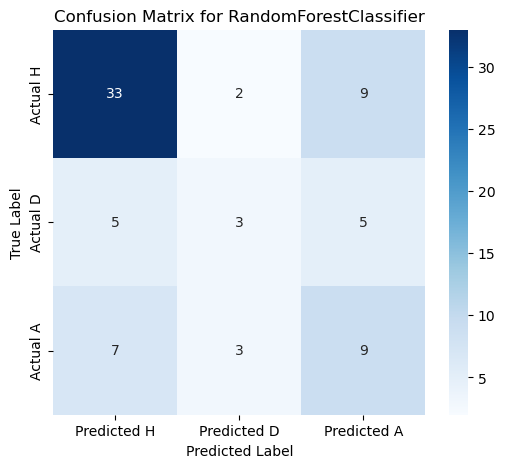


--- Training and Evaluating GradientBoostingClassifier ---
X_train shape: (304, 46)
X_train shape: (304, 46)
X_test shape: (76, 46)
y_train shape: (304,)
y_test shape: (76,)
Accuracy for GradientBoostingClassifier: 0.58

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.47      0.49        19
           D       0.19      0.23      0.21        13
           H       0.76      0.73      0.74        44

    accuracy                           0.58        76
   macro avg       0.48      0.48      0.48        76
weighted avg       0.60      0.58      0.59        76


Confusion Matrix:


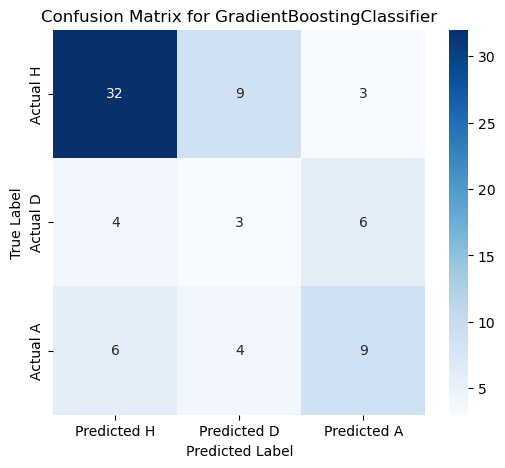


--- Training and Evaluating LogisticRegression ---
X_train shape: (304, 46)
X_train shape: (304, 46)
X_test shape: (76, 46)
y_train shape: (304,)
y_test shape: (76,)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy for LogisticRegression: 0.55

Classification Report:
              precision    recall  f1-score   support

           A       0.54      0.68      0.60        19
           D       0.20      0.31      0.24        13
           H       0.78      0.57      0.66        44

    accuracy                           0.55        76
   macro avg       0.51      0.52      0.50        76
weighted avg       0.62      0.55      0.57        76


Confusion Matrix:


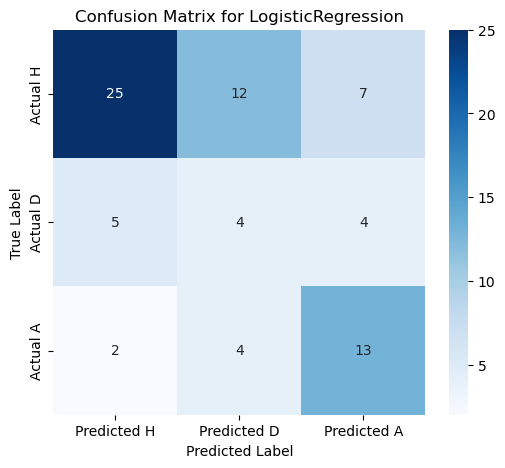

In [42]:
models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs', class_weight='balanced')
}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    print("X_train shape:", X_train.shape)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy for {name}: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=['H', 'D', 'A']) # Specify labels to ensure order
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted H', 'Predicted D', 'Predicted A'], yticklabels=['Actual H', 'Actual D', 'Actual A'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



In [45]:
print ('''

For this multi-class classification problem (Home Win, Draw, Away Win),
**RandomForestClassifier** performed better due to its robustness and ability to handle complex relationships.
''')



For this multi-class classification problem (Home Win, Draw, Away Win),
**RandomForestClassifier** performed better due to its robustness and ability to handle complex relationships.



# Visualization 


Top 10 Feature Importances (RandomForestClassifier):
                      Feature  Importance
5          AwayTeam_AvgPoints    0.100913
0     HomeTeam_AvgGoalsScored    0.100352
4   AwayTeam_AvgGoalsConceded    0.098912
3     AwayTeam_AvgGoalsScored    0.090475
1   HomeTeam_AvgGoalsConceded    0.090150
2          HomeTeam_AvgPoints    0.085786
16            Home_Man United    0.018998
7            Home_Bournemouth    0.015732
10        Home_Crystal Palace    0.014867
34             Away_Liverpool    0.014175


C:\Users\HP\AppData\Local\Temp\ipykernel_6388\357969737.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


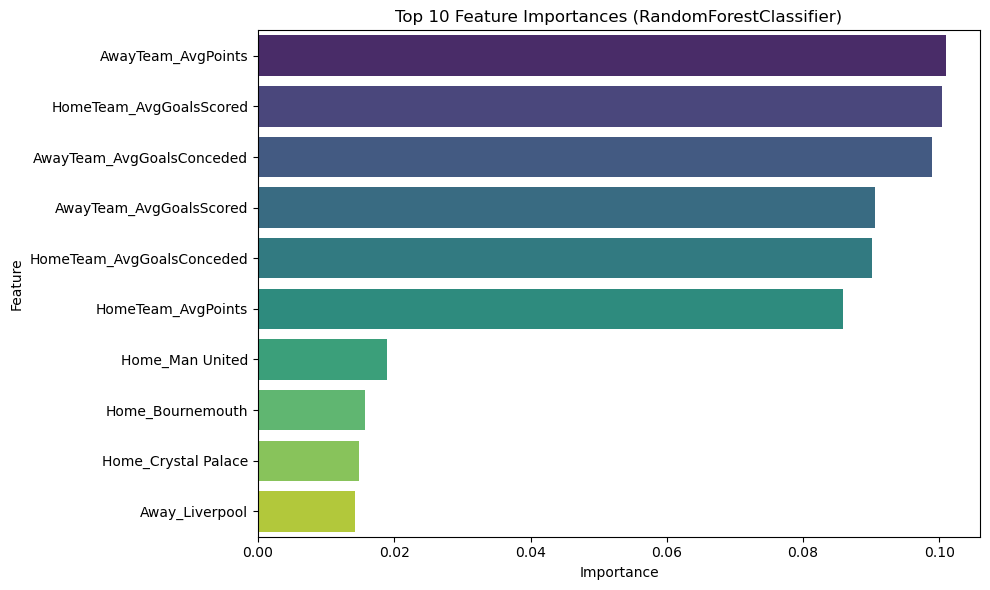

In [48]:
# Feature Importance (for RandomForestClassifier, as it's typically easy to interpret)
if "RandomForestClassifier" in models:
    rf_model = models["RandomForestClassifier"]
    importances = rf_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print("\nTop 10 Feature Importances (RandomForestClassifier):")
    print(feature_importance_df.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Feature Importances (RandomForestClassifier)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Correlation Matrix for numerical features

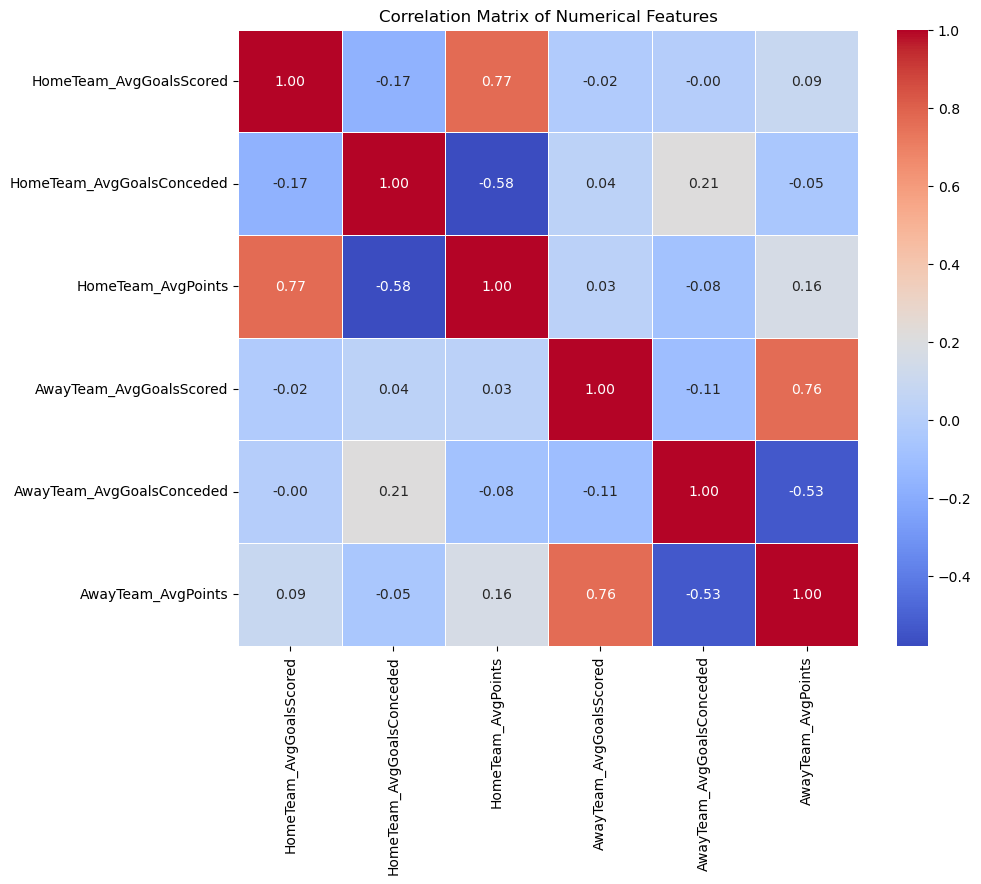

In [50]:
numerical_features = [
    'HomeTeam_AvgGoalsScored', 'HomeTeam_AvgGoalsConceded', 'HomeTeam_AvgPoints',
    'AwayTeam_AvgGoalsScored', 'AwayTeam_AvgGoalsConceded', 'AwayTeam_AvgPoints'
]

# Ensuring these columns exist in X_train before calculating correlation
existing_numerical_features = [f for f in numerical_features if f in X_train.columns]

if existing_numerical_features:
    correlation_matrix = X_train[existing_numerical_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=".5")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
else:
    print("\nNo numerical features found for correlation matrix visualization.")


# Prediction and Model Saving

In [52]:
import joblib

In [53]:
# saving the RandomForestClassifier as the best performing model

model_to_save = models["RandomForestClassifier"] 
model_filename = 'premier_league_match_predictor.pkl'
joblib.dump(model_to_save, model_filename)
print(f"\nModel saved as {model_filename}")



Model saved as premier_league_match_predictor.pkl


# Saving necessary metadata for the web app 

In [67]:
metadata = {
    'all_teams': all_possible_teams,
    'feature_columns': all_feature_columns
}
joblib.dump(metadata, 'model_metadata.pkl')
print("Model metadata (teams and feature columns) saved as model_metadata.pkl")


Model metadata (teams and feature columns) saved as model_metadata.pkl


In [69]:
example_home_team = 'Arsenal'
example_away_team = 'Man Utd'

# Create a dummy input DataFrame with the same columns as X_train
# All values initialized to 0, then fill in relevant features
dummy_input = pd.DataFrame(0, index=[0], columns=all_feature_columns)



In [73]:
# Fill in the team-specific one-hot encoded columns
if f'Home_{example_home_team}' in dummy_input.columns:
    dummy_input[f'Home_{example_home_team}'] = 1
if f'Away_{example_away_team}' in dummy_input.columns:
    dummy_input[f'Away_{example_away_team}'] = 1


In [75]:
# Fill in example engineered features (these would come from actual recent data)
dummy_input['HomeTeam_AvgGoalsScored'] = 1.5
dummy_input['HomeTeam_AvgGoalsConceded'] = 1.0
dummy_input['HomeTeam_AvgPoints'] = 2.0 # 2 points/game = W-D-L average

dummy_input['AwayTeam_AvgGoalsScored'] = 1.2
dummy_input['AwayTeam_AvgGoalsConceded'] = 1.3
dummy_input['AwayTeam_AvgPoints'] = 1.5


In [79]:
print(model_to_save.feature_names_in_)

['HomeTeam_AvgGoalsScored' 'HomeTeam_AvgGoalsConceded'
 'HomeTeam_AvgPoints' 'AwayTeam_AvgGoalsScored'
 'AwayTeam_AvgGoalsConceded' 'AwayTeam_AvgPoints' 'Home_Arsenal'
 'Home_Bournemouth' 'Home_Burnley' 'Home_Chelsea' 'Home_Crystal Palace'
 'Home_Everton' 'Home_Hull' 'Home_Leicester' 'Home_Liverpool'
 'Home_Man City' 'Home_Man United' 'Home_Middlesbrough' 'Home_Southampton'
 'Home_Stoke' 'Home_Sunderland' 'Home_Swansea' 'Home_Tottenham'
 'Home_Watford' 'Home_West Brom' 'Home_West Ham' 'Away_Arsenal'
 'Away_Bournemouth' 'Away_Burnley' 'Away_Chelsea' 'Away_Crystal Palace'
 'Away_Everton' 'Away_Hull' 'Away_Leicester' 'Away_Liverpool'
 'Away_Man City' 'Away_Man United' 'Away_Middlesbrough' 'Away_Southampton'
 'Away_Stoke' 'Away_Sunderland' 'Away_Swansea' 'Away_Tottenham'
 'Away_Watford' 'Away_West Brom' 'Away_West Ham']


In [81]:
# Example feature names (update these to match your model's feature names)
feature_names = ['feature1', 'feature2', 'feature3']
dummy_input = pd.DataFrame(data=[[value1, value2, value3]], columns=feature_names)

NameError: name 'value1' is not defined

In [77]:
# Make prediction using the RandomForestClassifier (or the chosen model_to_save)
predicted_outcome = model_to_save.predict(dummy_input)
predicted_proba = model_to_save.predict_proba(dummy_input)

outcome_map = {'H': 'Home Win', 'D': 'Draw', 'A': 'Away Win'}
print(f"\nPredicted outcome for {example_home_team} vs {example_away_team} (using {model_to_save.__class__.__name__}): {outcome_map[predicted_outcome[0]]}")
print(f"Prediction probabilities: Home Win: {predicted_proba[0][model_to_save.classes_.tolist().index('H')]:.2f}, "
      f"Draw: {predicted_proba[0][model_to_save.classes_.tolist().index('D')]:.2f}, "
      f"Away Win: {predicted_proba[0][model_to_save.classes_.tolist().index('A')]:.2f}")




ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
